```                
  __  __  _        __  _                   _______                 _     _                 
 |  \/  || |      / _|| |                 |__   __|               | |   (_)              
 | \  / || |     | |_ | |  ___ __      __    | | _ __  __ _   ___ | | __ _  _ __    __ _ 
 | |\/| || |     |  _|| | / _ \\ \ /\ / /    | || '__|/ _` | / __|| |/ /| || '_ \  / _` |
 | |  | || |____ | |  | || (_) |\ V  V /     | || |  | (_| || (__ |   < | || | | || (_| |
 |_|  |_||______||_|  |_| \___/  \_/\_/      |_||_|   \__,_| \___||_|\_\|_||_| |_| \__, |
                                                                                    __/ |
                                                                                   |___/ 
```

# Introduction

MLflow is an open source platform for managing the end-to-end machine learning lifecycle. 

It tackles three primary functions:

    1) Tracking experiments to record and compare parameters and results (MLflow Tracking).
    2) Packaging ML code in a reusable, reproducible form in order to share with other data scientists or transfer to production (MLflow Projects).
    3) Managing and deploying models from a variety of ML libraries to a variety of model serving and inference platforms (MLflow Models).

(source https://www.mlflow.org/docs/latest/index.html#mlflow-documentation)


# Part I. Machine learning cycle

In [1]:
# set working directory
%cd /home/mlflow-1-tracking/

/home/mlflow-1-tracking


In [15]:
import joblib
import itertools
import matplotlib.pyplot as plt
import mlflow
from mlflow import log_artifact, log_metric, log_param, log_params
from mlflow.tracking import MlflowClient
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load dataset

In [16]:
dataset = pd.read_csv('data/raw/iris.csv')
dataset.shape

(150, 5)

In [17]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [20]:
# feature names
feature_names = dataset.columns.tolist()[:4]
feature_names

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [21]:
# iris species
species = dataset['species'].unique().tolist()
species

['setosa', 'versicolor', 'virginica']

## Features engineering

In [22]:
dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']

dataset = dataset[[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
    'sepal_length_to_sepal_width', 'petal_length_to_petal_width',
    'species'
]]

In [23]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,species
0,5.1,3.5,1.4,0.2,1.457143,7.0,setosa
1,4.9,3.0,1.4,0.2,1.633333,7.0,setosa
2,4.7,3.2,1.3,0.2,1.468750,6.5,setosa
3,4.6,3.1,1.5,0.2,1.483871,7.5,setosa
4,5.0,3.6,1.4,0.2,1.388889,7.0,setosa


## Split dataset

In [24]:
test_size = 0.2

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### transform targets (species) to numerics

In [25]:
dataset.loc[dataset.species=='setosa', 'species'] = 0
dataset.loc[dataset.species=='versicolor', 'species'] = 1
dataset.loc[dataset.species=='virginica', 'species'] = 2

### Split in train/test

In [26]:
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

## Train

In [27]:
train_config = {
    'cv': 5,
    'estimator_name': 'LogisticRegression',
    'estimators': {
        'LogisticRegression': {
            'param_grid': {
                'C': [0.001, 0.01],
                'max_iter': [100, 200, 300],
                'solver': ['lbfgs'],
                'multi_class': ['multinomial']}},
        'SVC': {
            'param_grid': {
                'C': [0.1, 1.0],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale'],
                'degree': [3, 5]
            }
        }
    }
}

estimators = {
        'LogisticRegression': LogisticRegression,
        'SVC': SVC
}

In [29]:
# Get X and y
X_train = train_dataset.drop('species', axis=1)
y_train = train_dataset.species.astype('int8')

In [30]:
estimator_name = train_config['estimator_name']
estimator = estimators[estimator_name]()
f1_scorer = make_scorer(f1_score, average='weighted')
param_grid = train_config['estimators'][estimator_name]['param_grid']

clf = GridSearchCV(estimator=estimator,
                   param_grid=param_grid,
                   cv=train_config['cv'],
                   verbose=1,
                   scoring=f1_scorer,
                   iid=True)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(), iid=True,
             param_grid={'C': [0.001, 0.01], 'max_iter': [100, 200, 300],
                         'multi_class': ['multinomial'], 'solver': ['lbfgs']},
             scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [31]:
clf.best_score_

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.8783955615534562

## Evaluate

In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [37]:
Xtest = test_dataset.drop('species', axis=1)
Ytest = test_dataset.species.astype('int8')

In [38]:
y_pred = clf.predict(Xtest)

cm = confusion_matrix(y_pred, Ytest)
f1 = f1_score(y_true=Ytest, y_pred=y_pred, average='macro')

In [39]:
# f1 score value
f1

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9305555555555555

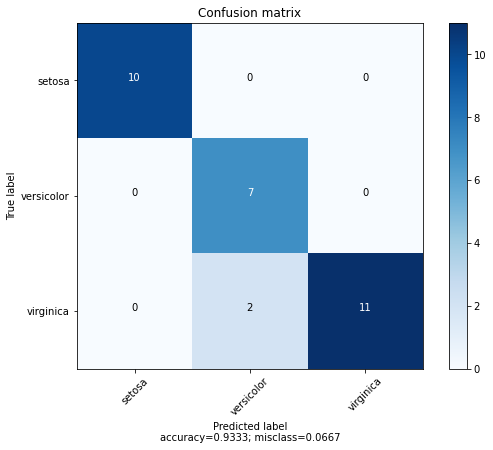

In [40]:
plot_confusion_matrix(cm, species, normalize=False)

## Persist model

In [ ]:
joblib.dump(clf, 'models/model.joblib')

# Part II. Logging to mlflow

## Log into mlflow

In [41]:

client = MlflowClient()

# Set experiment
mlflow.set_experiment(estimator_name)

# Start new run
with mlflow.start_run() as run:

    print(run)
    print(run.info)
    print(run.info.run_uuid)
    
    # Log parameters
    log_param(key='estimator', value=estimator_name)
    log_param(key='cv', value=train_config['cv'])
    log_params(param_grid)
    
    # Log metric
    log_metric(key='f1_score', value=f1)
    
    # Log artifacts
    log_artifact(local_path='models/model.joblib')

        

<ActiveRun: >
<RunInfo: artifact_uri='file:///home/mlflow-1-tracking/mlruns/0/0e074f37b5e54fbfb024b85090eaac2b/artifacts', end_time=None, experiment_id='0', lifecycle_stage='active', run_id='0e074f37b5e54fbfb024b85090eaac2b', run_uuid='0e074f37b5e54fbfb024b85090eaac2b', start_time=1608019875596, status='RUNNING', user_id='user'>
0e074f37b5e54fbfb024b85090eaac2b


client-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Some details

**1. Create MLflow client object:**

```python
client = MlflowClient()
```

> MlflowClient - Client of an MLflow Tracking Server that creates and manages experiments and runs.
source (https://www.mlflow.org/docs/latest/python_api/mlflow.tracking.html)


**2. Set experiment**

```python
mlflow.set_experiment(estimator_name)
```

- experiment contains runs intended. For example, we create experiments with estimator names: for each estimator - individual experiment.
- you can create experiments with different names
- ther Defualt experiment name


**3. Next step:**

```python
with mlflow.start_run() as run: 
```

- this code creates new run within current experiment, run is created automatically


**4. Log lparams, metrics & artifacts:**

```python

   # Log parameters
    log_param(key='estimator', value=estimator_name)
    log_param(key='cv', value=train_config['cv'])
    log_params(param_grid)
    
    # Log metric
    log_metric(key='f1_score', value=f1)
    
    # Log artifacts
    log_artifact(local_path='models/model.joblib')
    
```

**Mflow functions:**

1. log_param - logs one parameter, requires key (parameter name) and value;
2. log_params - multiple parameters logging function, it takes dictionary, keys of which are names and values are values of parameters;
3. log_metric - similar to log_param, but logs into separate column in MLflow UI
4. log_artifact - log file.

---

**Where you logs are stored?**

- When you set experiment or create new run first time then folder __mlruns__ is created automatically in working directory. 
- This folder contains folders with experiments and their runs.


# Open MLflow UI
    
    MLflow ui allow to observe experiments and runs, to compare model by metrics and select best model params.
    
    
Link to MLflow UI: http://0.0.0.0:5000